## Writeup Template

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

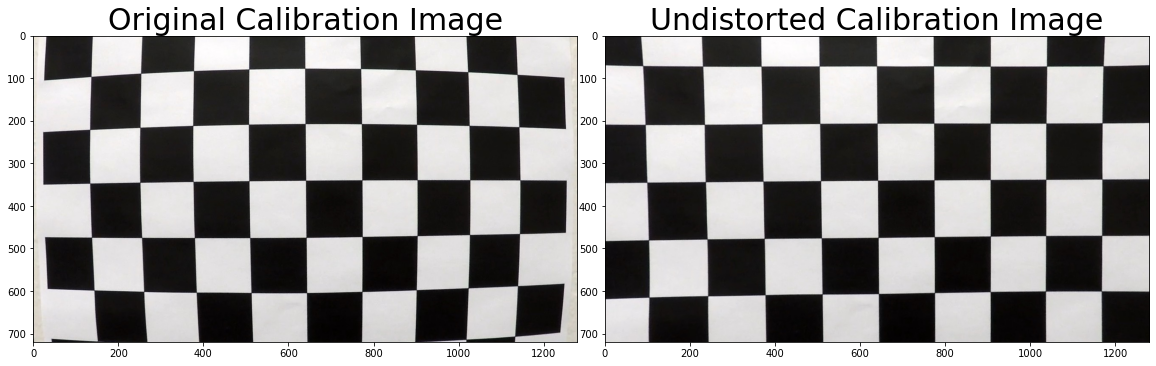

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
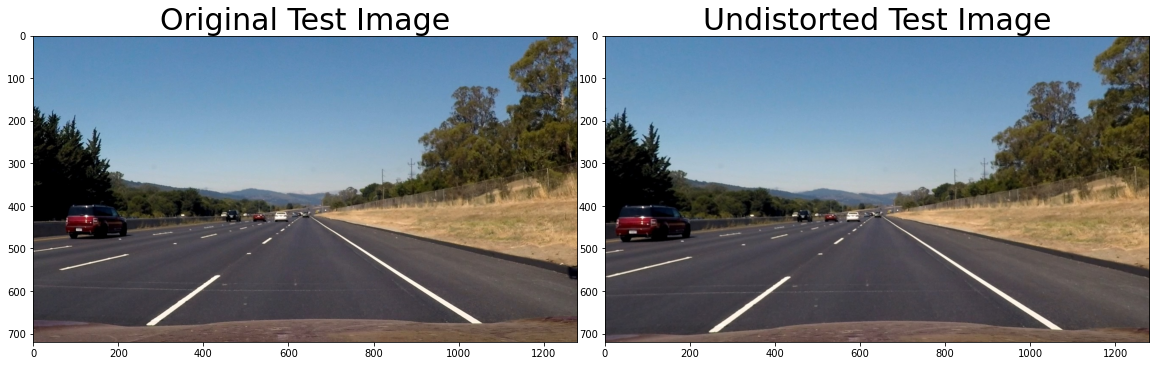

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image.

```python 
def apply_color_gradient_pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Run the pipeline
    sx_binary  = abs_sobel_thresh(image, orient='x', thresh_min=sx_thresh[0], thresh_max=sx_thresh[1])
    hls_binary = hls_select(image, thresh=(s_thresh[0], s_thresh[1]))
    # construct a new binary image using the above thresholded binary images 
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (hls_binary == 1)] = 1
    return combined_binary
```
Here's an example of my output for this step.

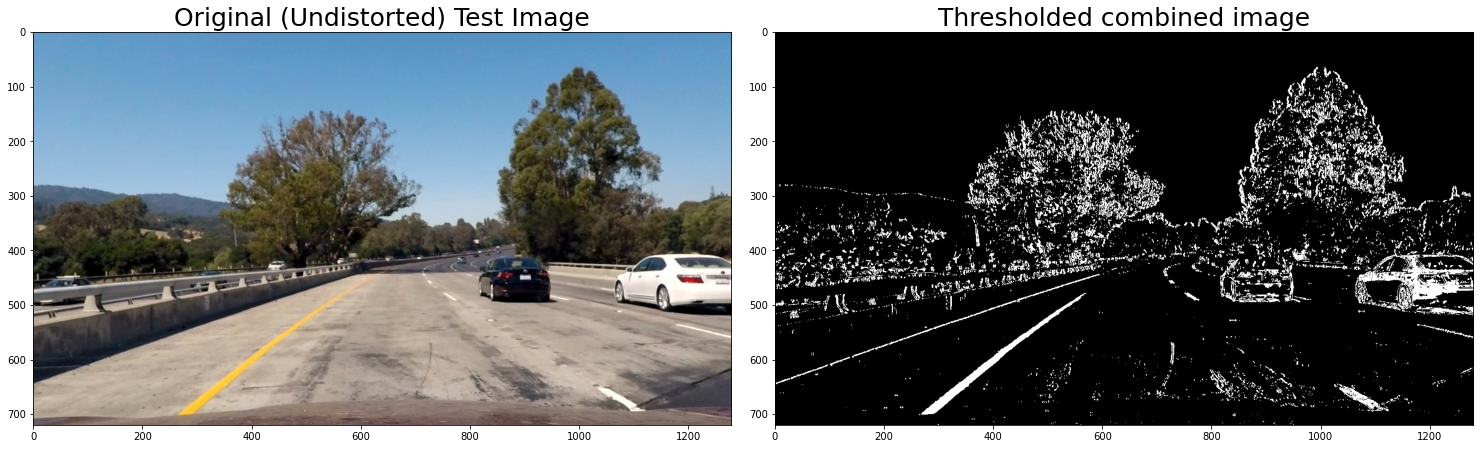

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp_image(image)`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warp_image(image)` function takes only as inputs an image (`image`).  I choose to hardcode the source and destination points in the following manner:

```python
src_pts = np.float32([[580.0, 460.0],[740.0, 460.0],[1100.0, 670.0],[270.0, 670.0]])
dst_pts = np.float32([[200.0, 0],[image.shape[1] - 200.0, 0],[image.shape[1] - 200.0, image.shape[0]],[200.0, image.shape[0]]])
```

This resulted in the following source and destination points:

                            | Source        | Destination | 
                            |:-------------:|:-----------:| 
                            | 585, 460      | 200, 0      | 
                            | 740, 460      | 1080, 0     |
                            | 1100, 670     | 1080, 720   |
                            | 695, 460      | 200.0, 720  |

I verified that my perspective transform was working as expected by drawing the `src_pts` and `dst_pts` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

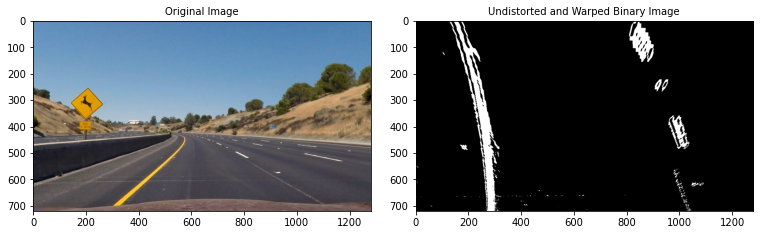

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

**In order to find the lane pixels from the warped image, I've used the sliding windows technique with margin = 100 as follows:**

```python 

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    # histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
```

**and based on the detected lane pixels on each lane seperately, I've used two functions to fit a line:**
**one function to find the fit parameters (2nd order poly) based on the pixel positions in the image as follows:**

```python 
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ## Pixel Coloring ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return out_img, left_fitx, right_fitx, ploty
```
**and another function to find the fit parameters (2nd order poly) based on the pixel positions in real world:**

```python 
def fit_polynomial_real(binary_warped, ym_per_pix, xm_per_pix):
    
    # Find our real lane pixels positions first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to pixel positions in each lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            
    return lefty, righty, left_fit_cr, right_fit_cr
```
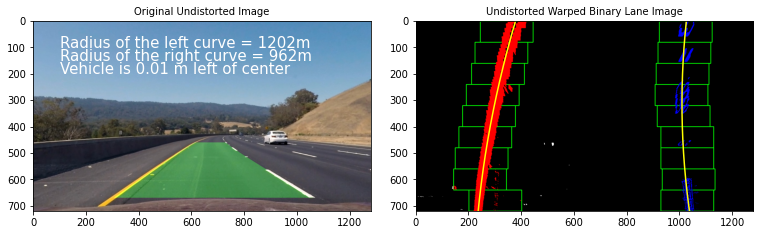

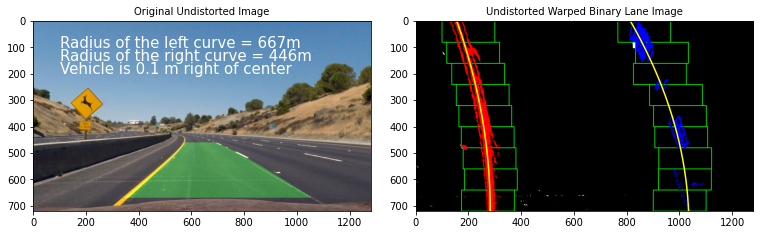

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

**in addition to the following two functions to find the curvature of the detected lanes, and car position with relative to the lane center**

```python 
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    lefty, righty, left_fit_cr, right_fit_cr = fit_polynomial_real(binary_warped, ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) /np.absolute(2*right_fit_cr[0])
        
    return left_curverad, right_curverad

def measure_car_position(binary_warped):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    _, __, left_fit_cr, right_fit_cr = fit_polynomial_real(binary_warped, ym_per_pix, xm_per_pix)
    image_center_m = (binary_warped.shape[1]/2)*xm_per_pix 
    # find the corresponding real x position in m for the image height (m)
    image_height_m = binary_warped.shape[0]*ym_per_pix
    left_fit_x_m = left_fit_cr[0]*image_height_m**2 + left_fit_cr[1]*image_height_m + left_fit_cr[2]
    right_fit_x_m = right_fit_cr[0]*image_height_m**2 + right_fit_cr[1]*image_height_m + right_fit_cr[2]
    lane_center_m = (right_fit_x_m + left_fit_x_m)/2
    vehicle_center = image_center_m - lane_center_m
    
    return vehicle_center
```

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step using the following function:
```python 

def generate_warped_with_lanes(undist_image, warped_binary_image, Minv, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    
    # return the Combined result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    return result 
```
Here is an example of my result on a test image:

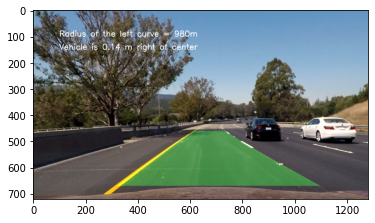

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video_output.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

My pipeline works very well with the project_video.mp4 but with the challenge_video.mp4, it didn't work quite well due to the unclear lanes on the video frames, and also due to moving the vehicle through a darked tunnel. 

**Conclusion**
1. Tuning the computer vision parameters is tricky. It needs some experience to get the best value. So It would be much easier to get the tuning parameters by implementing an openCV tuner GUI that shows the effect of selecting different parameters on the output image as follows for example: 


2. Using deep learning for computer vision is a great breakthrough, and the resulting pipeline would be much improved if some neural network is used which I am really looking forward to use in the upcoming lessons. 